# 库导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
import time
import scipy

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 相关交易日

## 交易日期数据

In [2]:
TradeDateDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareCalendar'))
TradeDateDf = TradeDateDf[TradeDateDf['S_INFO_EXCHMARKET'] == 'SSE']
TradeDateDf_D = TradeDateDf['TRADE_DAYS'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d')).to_frame('TRADE_DAYS').sort_values('TRADE_DAYS')

TradeDateDf_D_Used = TradeDateDf_D[(TradeDateDf_D['TRADE_DAYS']>='2005-01-01') & (TradeDateDf_D['TRADE_DAYS']<='2019-07-31')]
TradeDateDf_D_Used.index = TradeDateDf_D_Used['TRADE_DAYS']
TradeDateDf_D_Used.index.names = ['NOT_TRADE_DAYS']

TradeDateDf_M_Used = TradeDateDf_D_Used.resample('M').last()
TradeDateDf_M_Used.index.names = ['NOT_TRADE_DAYS']

## 日期转换函数

In [3]:
# 月度非标准数据的日期转变为当月（若t>t_end，下个月）最后一个交易日
def MdateToMENDdate(FinancialIndicatorDf,TradeDateDf_M_Used,colname):
    '''
    第1参数，DF，包含 colname 列，公告日期，
    第2参数，DF，包含 TRADE_DAYS 列，为月度交易日，
    '''
    FinancialIndicatorDf_1 = FinancialIndicatorDf.copy()
    FinancialIndicatorDf_end = FinancialIndicatorDf.copy()
    ## 可更改，根据ANN_DT列是否为日期
    try:
        FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
    except:
        FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname]
    #################################
    TradeDateDf_M_Used_ = TradeDateDf_M_Used.copy()
    TradeDateDf_M_Used_['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in TradeDateDf_M_Used['TRADE_DAYS'].tolist()].copy()
    FinancialIndicatorDf_1['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in FinancialIndicatorDf_1['TRADE_DAYS_tmp'].tolist()]
    FinancialIndicatorDf_2 = FinancialIndicatorDf_1.merge(TradeDateDf_M_Used_,on=['TRADE_DAYS_Y_M'],how='left')
    TradeDateDf_M_Used_DateList = TradeDateDf_M_Used_['TRADE_DAYS'].tolist()
    FinancialIndicatorDf_3 = FinancialIndicatorDf_2.copy()
#     FinancialIndicatorDf_3['TRADE_DAYS'] = FinancialIndicatorDf_3.apply(lambda x: 
#                                                                         TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
#                                                                         if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
#                                                                         else x['TRADE_DAYS'] ,axis=1)
    FinancialIndicatorDf_end[colname]= FinancialIndicatorDf_3.apply(lambda x: 
                                                                        TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
                                                                        if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
                                                                        else x['TRADE_DAYS'] ,axis=1)
    return FinancialIndicatorDf_end

# 股票池筛选

## 获取全股票池

In [4]:
# 以行情信息对应的日度股票列表筛选得到月度可选股列表
DfForStock = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODPrices'))
DfForStock_0 = DfForStock[['S_INFO_WINDCODE','TRADE_DT']].copy()
DfForStock_0['TRADE_DAYS'] = DfForStock_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
DfForStock_0=DfForStock_0[['S_INFO_WINDCODE','TRADE_DAYS']].copy()

In [5]:
# 日度股票列表月度化
DfForStock_1=DfForStock_0.set_index('TRADE_DAYS')
DfForStock_1['TRADE_DAYS']=DfForStock_1.index
DfForStock_2=DfForStock_1.groupby('S_INFO_WINDCODE').apply(lambda x:x.resample('M').last())
DfForStock_3=DfForStock_2.reset_index(drop=True)

## 删除上市未满6个月股票

In [6]:
IPODF = pd.read_csv('D:/DWDB/%s.csv'%'AShareIPO')
IPODF['S_IPO_LISTDATE']=IPODF['S_IPO_LISTDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
IPODF_0 = IPODF[['S_INFO_WINDCODE','S_IPO_LISTDATE']]

DfForStock_4 = DfForStock_3.merge(IPODF_0,on=['S_INFO_WINDCODE'],how='left')
DfForStock_4['IPOtitlNow'] = DfForStock_4['TRADE_DAYS']-DfForStock_4['S_IPO_LISTDATE']
DfForStock_4['IPOtitlNowIF'] = DfForStock_4['IPOtitlNow'].apply(lambda x: 1 if x.days>182 else 0)

DfForStock_5 = DfForStock_4[DfForStock_4['IPOtitlNowIF']==1][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

## 删除有特殊处理的股票

In [7]:
STDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareST')
STDF['ENTRY_DT'] = STDF['ENTRY_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF['REMOVE_DT'] = STDF['REMOVE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF_0 = STDF[['S_INFO_WINDCODE','ENTRY_DT','REMOVE_DT','S_TYPE_ST']].copy()
STDF_0['REMOVE_DT'] = STDF_0['REMOVE_DT'].fillna(datetime.datetime.strptime('2099-12-31','%Y-%m-%d'))

In [8]:
DfForStock_6=DfForStock_5.merge(STDF_0,left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['ENTRY_DT','S_INFO_WINDCODE'],how='left')
DfForStock_6=DfForStock_6[DfForStock_6['ENTRY_DT'].isnull()][['TRADE_DAYS','S_INFO_WINDCODE']].copy()
DfForStock_7=DfForStock_6.merge(MdateToMENDdate(STDF_0,TradeDateDf_M_Used,'ENTRY_DT'),left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['ENTRY_DT','S_INFO_WINDCODE'],how='left')

In [9]:
def FillNaT(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    df_=df_.fillna(method='ffill')
    return df_
DfForStock_8=DfForStock_7.groupby('S_INFO_WINDCODE').apply(FillNaT).reset_index(drop=True)

In [10]:
DfForStock_9=DfForStock_8[~(DfForStock_8['TRADE_DAYS']<=DfForStock_8['REMOVE_DT'])][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

## 剔除停牌股票

In [11]:
TradingSuspensionDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareTradingSuspension')
TradingSuspensionDF_0 = TradingSuspensionDF[['S_INFO_WINDCODE','S_DQ_SUSPENDDATE','S_DQ_RESUMPDATE']].copy()
TradingSuspensionDF_0['S_DQ_SUSPENDDATE']=TradingSuspensionDF_0['S_DQ_SUSPENDDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
TradingSuspensionDF_0['S_DQ_RESUMPDATE']=TradingSuspensionDF_0['S_DQ_RESUMPDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)

TradingSuspensionDF_1=TradingSuspensionDF_0.copy()
TradingSuspensionDF_1['S_DQ_RESUMPDATE']=TradingSuspensionDF_1.apply(lambda x: x['S_DQ_SUSPENDDATE'] if pd.isnull(x['S_DQ_RESUMPDATE']) else x['S_DQ_RESUMPDATE'],axis=1)

TradingSuspensionDF_2=MdateToMENDdate(TradingSuspensionDF_1,TradeDateDf_M_Used,'S_DQ_SUSPENDDATE')
TradingSuspensionDF_3=TradingSuspensionDF_2[~(TradingSuspensionDF_2['S_DQ_SUSPENDDATE']>TradingSuspensionDF_2['S_DQ_RESUMPDATE'])]

DfForStock_10=DfForStock_9.merge(TradingSuspensionDF_3,left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['S_DQ_SUSPENDDATE','S_INFO_WINDCODE'],how='left')
DfForStock_11=DfForStock_10.groupby('S_INFO_WINDCODE').apply(FillNaT).reset_index(drop=True)
DfForStock_12=DfForStock_11[~(DfForStock_11['TRADE_DAYS']<=DfForStock_11['S_DQ_RESUMPDATE'])][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

DfForStock_V = DfForStock_12.copy()

# 动量因子计算
## 多窗口动量因子

In [12]:
AllPriceData=DfForStock.copy()
AllPriceData_0 = AllPriceData[['S_INFO_WINDCODE','TRADE_DT','S_DQ_ADJCLOSE']].copy()
AllPriceData_0['TRADE_DAYS'] = AllPriceData_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not pd.isnull(x) else np.nan)
AllPriceData_1=AllPriceData_0[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()

In [18]:
AllPriceData_1.head()

,S_INFO_WINDCODE,TRADE_DAYS,S_DQ_ADJCLOSE
0,000878.SZ,2005-01-04,8.12
1,000880.SZ,2005-01-04,9.12
2,000881.SZ,2005-01-04,14.03
3,000882.SZ,2005-01-04,5.70
4,000883.SZ,2005-01-04,5.29


In [19]:
# 个股行情数据，个股收益率
DfForRet=AllPriceData_1[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()
def ComputeRet(df,datename,colname):
    df_=df.sort_values(datename).copy()
    df_['Ret']=df_[colname]/df_[colname].shift(1)-1
    return df_
DfForRet_0=DfForRet.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='S_DQ_ADJCLOSE').reset_index(drop=True)

In [20]:
def ComputeMom(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    Rprod=np.exp(np.log(df_['Ret'][-MomN:]+1).sum())-1
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','Mom_%s'%(MomN)]).T
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
def ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_2,ComputeBeta,StartN,UsedN):
    '''
    日度数据计算月度因子专用函数
    TradeDateDf_M_Used,循环交易日DF
    DfForRet_2,原材料数据集
    StartN,因子计算起始窗口
    UsedN,因子计算所需数据长度
    '''
    DateList=TradeDateDf_M_Used['TRADE_DAYS']
    SaveDf=pd.DataFrame()
    for DateCnt in range(StartN,len(DateList)):
        DateNow=DateList[DateCnt]
        DateLast=DateList[DateCnt-UsedN]
        DfForRet_2_sub=DfForRet_2[(DfForRet_2['TRADE_DAYS']<=DateNow)&(DfForRet_2['TRADE_DAYS']>=DateLast)].copy()
        DfForRet_2_sub0=DfForRet_2_sub[DfForRet_2_sub['S_INFO_WINDCODE'].isin(DfForStock_V[DfForStock_V['TRADE_DAYS']==DateNow]['S_INFO_WINDCODE'])]
        DfForRet_2_sub1=applyParallel(DfForRet_2_sub0.groupby('S_INFO_WINDCODE'),ComputeBeta)
        DfForRet_2_sub1['TRADE_DAYS']=DateNow
        SaveDf=pd.concat([SaveDf,DfForRet_2_sub1],axis=0)
    return SaveDf

In [22]:
MomDf={}
MomNList=[5,10,20,60,120,240]
for MomN in MomNList:
    MomDf[MomN]=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_0,ComputeMom,12,6)

In [23]:
MomFct=pd.DataFrame(columns=['S_INFO_WINDCODE','TRADE_DAYS'])
for key in MomDf.keys():
    MomFct_tmp=MomDf[key]
    MomFct=MomFct.merge(MomFct_tmp,on=['S_INFO_WINDCODE','TRADE_DAYS'],how='outer')
MomFct=MomFct.dropna()

In [24]:
for col in ['Mom_'+str(c) for c in MomNList]:
    MomFct[col]=MomFct[col].astype("float")

## 读取Barra因子库

In [35]:
BarraFactorNextR=pd.read_csv('D:/StockDataBase/BarraFactorNextR.csv',parse_dates=['TRADE_DAYS'])
del BarraFactorNextR['EARN']

In [36]:
BarraMomFct=BarraFactorNextR.merge(MomFct,on=['S_INFO_WINDCODE','TRADE_DAYS'],how='left').groupby(['S_INFO_WINDCODE','TRADE_DAYS']).mean().reset_index()

In [43]:
def data_neutral(df):
    df_ = df.copy()
    X = pd.get_dummies(df_[['SIZE','IND']],columns=['IND'])
    FactorNames = ['Mom_'+str(c) for c in MomNList]
    for colname in FactorNames:
        y = df_[[colname]]
        residSeries = sm.OLS(y,X).fit().resid
        df_[colname] = residSeries
    return df_

In [44]:
BarraMomFct_=BarraMomFct.groupby(['TRADE_DAYS']).apply(data_neutral).reset_index(drop=True)

## 普通动量效应

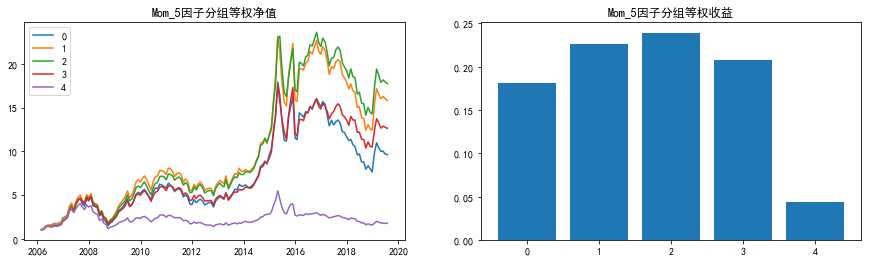

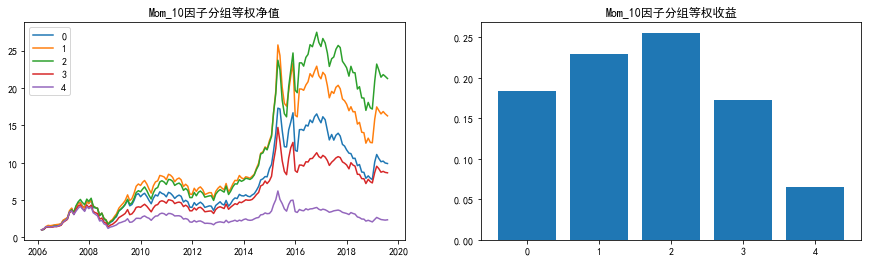

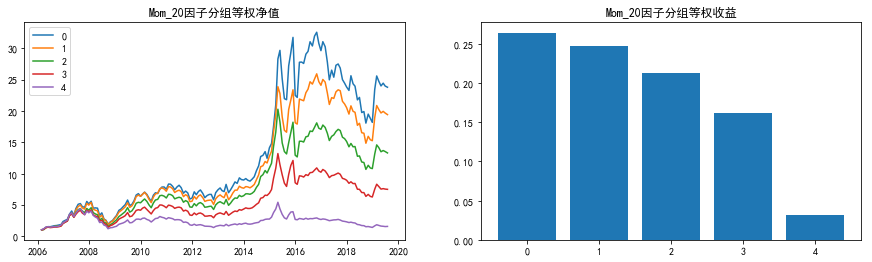

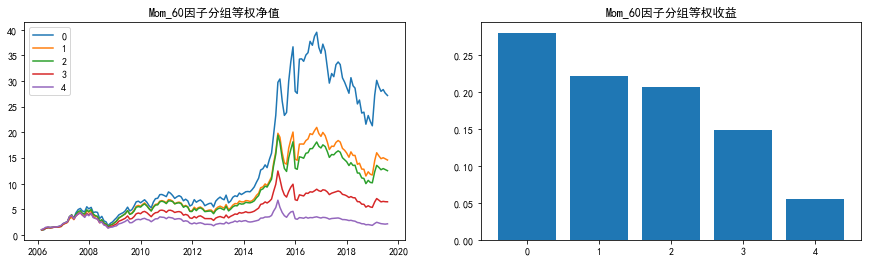

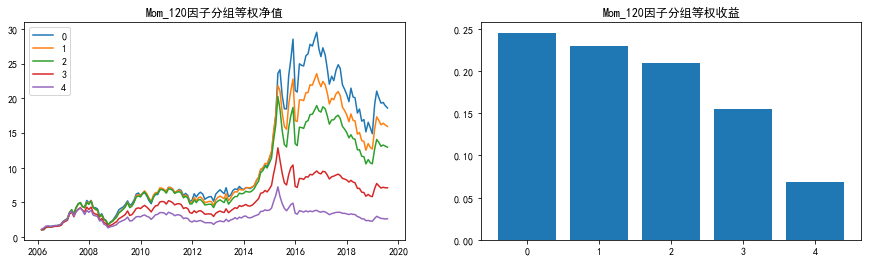

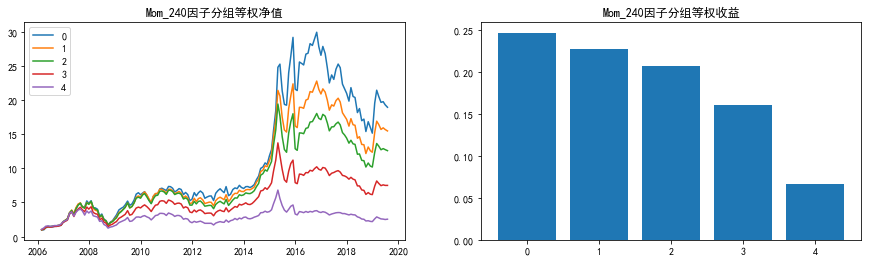

In [49]:
# 计算因子分组收益
def Cut(df,col,N):
    df_=df.copy()
    df_['G']=pd.qcut(df_[col],N,labels=False,duplicates='drop')
    return df_
def ComputYearlyRet(df,col):
    df_=df.sort_values('TRADE_DAYS').copy()
    last=(df_['TRADE_DAYS'].tolist()[-1]-df_['TRADE_DAYS'].tolist()[0]).days
    YearlyRet=(df_[col].tolist()[-1]/df_[col].tolist()[0])**(365.25/last)-1
    return YearlyRet

FacrotList=['Mom_'+str(c) for c in MomNList]
Used_FactorDf = BarraMomFct.copy()
for col in FacrotList:
    BarraFactorNextR_sub=Used_FactorDf[['S_INFO_WINDCODE','TRADE_DAYS','NextRet',col]].copy()
    BarraFactorNextR_sub0=BarraFactorNextR_sub.groupby('TRADE_DAYS').apply(Cut,col=col,N=5).reset_index(drop=True)
    BarraFactorNextR_sub1=BarraFactorNextR_sub0.groupby(['TRADE_DAYS','G']).mean().reset_index()
    FactorEquity=(BarraFactorNextR_sub1.pivot_table(index='TRADE_DAYS',columns='G',values='NextRet')+1).cumprod()
    FactorAvgR=BarraFactorNextR_sub1.groupby('G').mean()[['NextRet']]*12
    FactorYearlyR=FactorEquity.unstack().to_frame(col).reset_index().groupby('G').apply(ComputYearlyRet,col).to_frame(col)
    fig=plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,2,1)
    ax1.plot(FactorEquity)
    ax1.legend(FactorEquity.columns,loc=0)
    plt.title('%s因子分组等权净值'%(col))
    ax2=fig.add_subplot(1,2,2)
    # 年化收益
    ax2.bar(FactorYearlyR.index,FactorYearlyR[col])
    # 平均收益
#     ax2.bar(FactorAvgR.index,FactorAvgR['NextRet'])
    plt.title('%s因子分组等权收益'%(col))
    plt.show()

A股似乎并不存在长期动量效应，长期表现出单调性较好的反转特性。

## 低波动异象分解

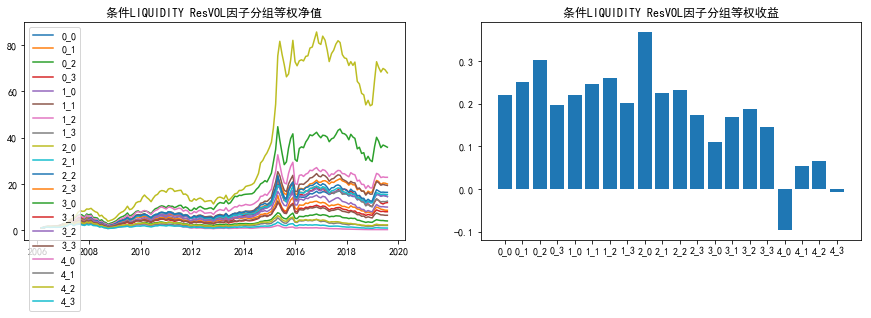

In [104]:
# 计算因子分组收益
def CutMulti(df,col,N):
    df_=df.copy()
    df_['G_%s'%(col)]=pd.qcut(df_[col],N,labels=False,duplicates='drop')
    return df_
def ComputYearlyRet(df,col):
    df_=df.sort_values('TRADE_DAYS').copy()
    last=(df_['TRADE_DAYS'].tolist()[-1]-df_['TRADE_DAYS'].tolist()[0]).days
    YearlyRet=(df_[col].tolist()[-1]/df_[col].tolist()[0])**(365.25/last)-1
    return YearlyRet

FacrotList=['Mom_'+str(c) for c in MomNList]
FacrotList=['ResVOL']
ConditionFct='LIQUIDITY'
Used_FactorDf = BarraMomFct.copy()
for col in FacrotList:
    BarraFactorNextR_sub=Used_FactorDf[['S_INFO_WINDCODE','TRADE_DAYS','NextRet',col,ConditionFct]].copy()
    BarraFactorNextR_sub0=BarraFactorNextR_sub.groupby('TRADE_DAYS').apply(CutMulti,col=col,N=4).reset_index(drop=True)
    BarraFactorNextR_sub1=BarraFactorNextR_sub0.groupby('TRADE_DAYS').apply(CutMulti,col=ConditionFct,N=5).reset_index(drop=True)
    BarraFactorNextR_sub2=BarraFactorNextR_sub1.groupby(['TRADE_DAYS','G_%s'%(col),'G_%s'%(ConditionFct)]).mean().reset_index()
    BarraFactorNextR_sub2['%s_Mom'%(ConditionFct)]=BarraFactorNextR_sub2['G_%s'%(ConditionFct)].apply(lambda x: str(x))+'_'+BarraFactorNextR_sub2['G_%s'%(col)].apply(lambda x: str(x))
    FactorEquity=(BarraFactorNextR_sub2.pivot_table(index='TRADE_DAYS',columns='%s_Mom'%(ConditionFct),values='NextRet')+1).cumprod()
    FactorAvgR=BarraFactorNextR_sub2.groupby('%s_Mom'%(ConditionFct)).mean()[['NextRet']]*12
    FactorYearlyR=FactorEquity.unstack().to_frame(col).reset_index().groupby('%s_Mom'%(ConditionFct)).apply(ComputYearlyRet,col).to_frame(col)
    fig=plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,2,1)
    ax1.plot(FactorEquity)
    ax1.legend(FactorEquity.columns,loc=0)
    plt.title('条件%s %s因子分组等权净值'%(ConditionFct,col))
    ax2=fig.add_subplot(1,2,2)
    # 年化收益
    ax2.bar(FactorYearlyR.index,FactorYearlyR[col])
    # 平均收益
#     ax2.bar(FactorAvgR.index,FactorAvgR['NextRet'])
    plt.title('条件%s %s因子分组等权收益'%(ConditionFct,col))
    plt.show()

全横截面上低波动异象是存在的，与理论“波动越低，风险越低，期望收益越低”相反；  
使用流动性对波动因子进行double-sort后，低波动异象得到一定解释：在流动性从低到高的5组中，第1、2、4、5组的组内收益均呈现出一致的走势——组内前3组收益随着波动增加单调递增，最大波动组收益较低；  
固定流动性后，组内的收益随着波动的增大而增大，与理论是相符合的，最大（历史）波动组似乎不被投资者偏好，可能意味着过大的不确定性，尾部风险的发生侵蚀了预期收益的一部分。

# 波动因子计算
为研究低风险异象，计算5类（可能增加）衡量风险的因子：  
1) 普通波动率；  
$ Vol_i=std(r_i) $  

2) 非系统性风险；  
$ r^{ex}_i=r_i-r_{bm} $  
$ NsVol_i=std(r^{ex}_i) $  

3) 残差波动率；  
$ r_i=\alpha_i+\beta\times r_{bm}+\epsilon_i $  
$ RVol_i = std(\epsilon_i) $  

4) 系统性风险；  
$ SVol_i=\beta_i $  

5) 偏度；  
$ SkVol_i $

6) 峰度；  
$ KuVol_i $

## 行情数据

In [22]:
AllPriceData=DfForStock.copy()
AllPriceData_0 = AllPriceData[['S_INFO_WINDCODE','TRADE_DT','S_DQ_ADJCLOSE']].copy()
AllPriceData_0['TRADE_DAYS'] = AllPriceData_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not pd.isnull(x) else np.nan)
AllPriceData_1=AllPriceData_0[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()

## 指数数据

In [24]:
IndexHS300Weight = pd.read_csv('D:/DWDB/%s.csv'%('AIndexHS300FreeWeight'))
IndexHS300Weight['TRADE_DAYS'] = IndexHS300Weight['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
IndexEODPrices = pd.read_csv('D:/DWDB/%s.csv'%('AIndexEODPrices'))
IndexEODPrices['TRADE_DAYS'] = IndexEODPrices['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

In [25]:
benchmarkI = '000905.SH'

In [26]:
IndexPrices=IndexEODPrices[IndexEODPrices['S_INFO_WINDCODE']==benchmarkI][['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_CLOSE']].copy()
IndexPrices['基准指数']=IndexPrices['S_DQ_CLOSE']

## 收益率计算

In [27]:
# 个股行情数据，个股收益率
DfForRet=AllPriceData_1[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()
def ComputeRet(df,datename,colname):
    df_=df.sort_values(datename).copy()
    df_['Ret']=df_[colname]/df_[colname].shift(1)-1
    return df_
DfForRet_0=DfForRet.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='S_DQ_ADJCLOSE').reset_index(drop=True)

In [28]:
# 指数行情数据，指数收益率
DfForRet_Index=IndexPrices[['S_INFO_WINDCODE','TRADE_DAYS','基准指数']].copy()
DfForRet_Index_0=DfForRet_Index.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='基准指数').reset_index(drop=True)
DfForRet_Index_1=DfForRet_Index_0.rename(columns={'Ret':'基准指数Ret'})

## 各类低风险因子计算

In [29]:
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
def ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_2,ComputeBeta,StartN,UsedN):
    '''
    日度数据计算月度因子专用函数
    TradeDateDf_M_Used,循环交易日DF
    DfForRet_2,原材料数据集
    StartN,因子计算起始窗口
    UsedN,因子计算所需数据长度
    '''
    DateList=TradeDateDf_M_Used['TRADE_DAYS']
    SaveDf=pd.DataFrame()
    for DateCnt in range(StartN,len(DateList)):
        DateNow=DateList[DateCnt]
        DateLast=DateList[DateCnt-UsedN]
        DfForRet_2_sub=DfForRet_2[(DfForRet_2['TRADE_DAYS']<=DateNow)&(DfForRet_2['TRADE_DAYS']>=DateLast)].copy()
        DfForRet_2_sub0=DfForRet_2_sub[DfForRet_2_sub['S_INFO_WINDCODE'].isin(DfForStock_V[DfForStock_V['TRADE_DAYS']==DateNow]['S_INFO_WINDCODE'])]
        DfForRet_2_sub1=applyParallel(DfForRet_2_sub0.groupby('S_INFO_WINDCODE'),ComputeBeta)
        DfForRet_2_sub1['TRADE_DAYS']=DateNow
        SaveDf=pd.concat([SaveDf,DfForRet_2_sub1],axis=0)
    return SaveDf

### 普通波动率

In [30]:
def ComputeVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    Rprod=(df_['Ret'][-252:]).std()
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','Vol']).T

In [31]:
Vol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_0.dropna(),ComputeVol,12,12)

### 非系统性风险

In [32]:
def ComputeNsVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    r_i=df_['Ret'][-252:]
    r_bm=df_['基准指数Ret'][-252:]
    r_ex=r_i-r_bm
    Rprod=r_ex.std()
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','NsVol']).T

In [33]:
DfForRet_1=DfForRet_0.merge(DfForRet_Index_1[['TRADE_DAYS','基准指数Ret']].copy(),on=['TRADE_DAYS'],how='left').dropna()
NsVol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_1,ComputeNsVol,12,12)

### 残差波动率与系统性风险

In [34]:
def ComputeR_SVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    r_i=df_['Ret'][-252:]
    r_bm=df_['基准指数Ret'][-252:]
    r_bm_c=sm.add_constant(r_bm)
    RegResult=sm.OLS(r_i,r_bm_c).fit()
    beta=RegResult.params[1]
    rvol=np.std(RegResult.resid)
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],beta,rvol],index=['S_INFO_WINDCODE','SVol','RVol']).T

In [35]:
R_SVol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_1,ComputeR_SVol,12,12)

### 峰度偏度

In [36]:
def ComputeK_FVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    r_i=df_['Ret'][-252:]
    skew=r_i.skew()
    kurt=r_i.kurt()
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],skew,kurt],index=['S_INFO_WINDCODE','SkVol','KuVol']).T

In [37]:
K_FVol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_1,ComputeK_FVol,12,12)

## 与Barra因子合并

In [38]:
BarraFactorNextR=pd.read_csv('D:/StockDataBase/BarraFactorNextR.csv',parse_dates=['TRADE_DAYS'])
del BarraFactorNextR['EARN']

In [39]:
# 计算月度收益
def DoM(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    df_.index=df_['TRADE_DAYS']
    df_0=df_.apply(lambda x: x.resample('M').last()).reset_index(drop=True)
    df_0['Ret']=df_0['S_DQ_ADJCLOSE']/df_0['S_DQ_ADJCLOSE'].shift(1)-1
    return df_0
AllPriceData_M=AllPriceData_0[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].groupby('S_INFO_WINDCODE').apply(DoM).reset_index(drop=True).dropna()

In [40]:
BarraFactorNextR_0=BarraFactorNextR.copy()
names=locals()
for name in ['Vol','NsVol','R_SVol','K_FVol',]:
    BarraFactorNextR_0=BarraFactorNextR_0.merge(names['%s_Df'%(name)],on=['S_INFO_WINDCODE','TRADE_DAYS'],how='left')

## 横截面标准化

In [45]:
riskFactors=['Vol','NsVol','RVol','SVol','SkVol','KuVol',]

In [55]:
#构建绝对中位数处理法函数
def extreme_process_MAD(data,cols,num=3):#data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准
    data_=data.copy()  # 为不破坏原始数据，先对其进行拷贝 
    feature_names = cols   #获取数据集中需测试的因子名
    median=data_[feature_names].median(axis=0)  #获取中位数
    MAD=abs(data_[feature_names].sub(median,axis=1)).median(axis=0) #按列索引匹配，并在行中广播
    data_.loc[:,feature_names]=data_.loc[:,feature_names].clip(lower=median-num*1.4826*MAD,upper=median+num*1.4826*MAD,axis=1) #利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    return data_

In [56]:
def fillnull_process(df,cols):
    NumFactorName = cols
    MedianSeries = df[NumFactorName].median()
    return df.fillna(dict(zip(MedianSeries.index,MedianSeries.values)))

In [57]:
def scale_Zscore(df,cols):
    df_ = df.copy()
    FactorNames = cols
    df_.loc[:,FactorNames] = (df_.loc[:,FactorNames].sub(df_.loc[:,FactorNames].mean(),axis=1)).div(df_.loc[:,FactorNames].std(),axis=1)
    return df_

In [58]:
# 缩尾处理
# BarraFactorNextR_1=BarraFactorNextR_0.groupby('TRADE_DAYS').apply(extreme_process_MAD,cols=riskFactors).reset_index(drop=True)
# BarraFactorNextR_2=BarraFactorNextR_1.groupby(['TRADE_DAYS','IND']).apply(fillnull_process,cols=riskFactors).reset_index(drop=True)
# BarraFactorNextR_3=BarraFactorNextR_2.groupby(['TRADE_DAYS']).apply(scale_Zscore,cols=riskFactors).reset_index(drop=True)

In [62]:
# 不缩尾处理
BarraFactorNextR_2=BarraFactorNextR_0.groupby(['TRADE_DAYS','IND']).apply(fillnull_process,cols=riskFactors).reset_index(drop=True)
BarraFactorNextR_3=BarraFactorNextR_2.groupby(['TRADE_DAYS']).apply(scale_Zscore,cols=riskFactors).reset_index(drop=True)

In [63]:
BarraFactorR_0=BarraFactorNextR_3.merge(AllPriceData_M[['S_INFO_WINDCODE','TRADE_DAYS','Ret']],on=['S_INFO_WINDCODE','TRADE_DAYS'],how='left')

# 风险因子分析

## 风险类因子的相关性

<Figure size 1080x864 with 0 Axes>

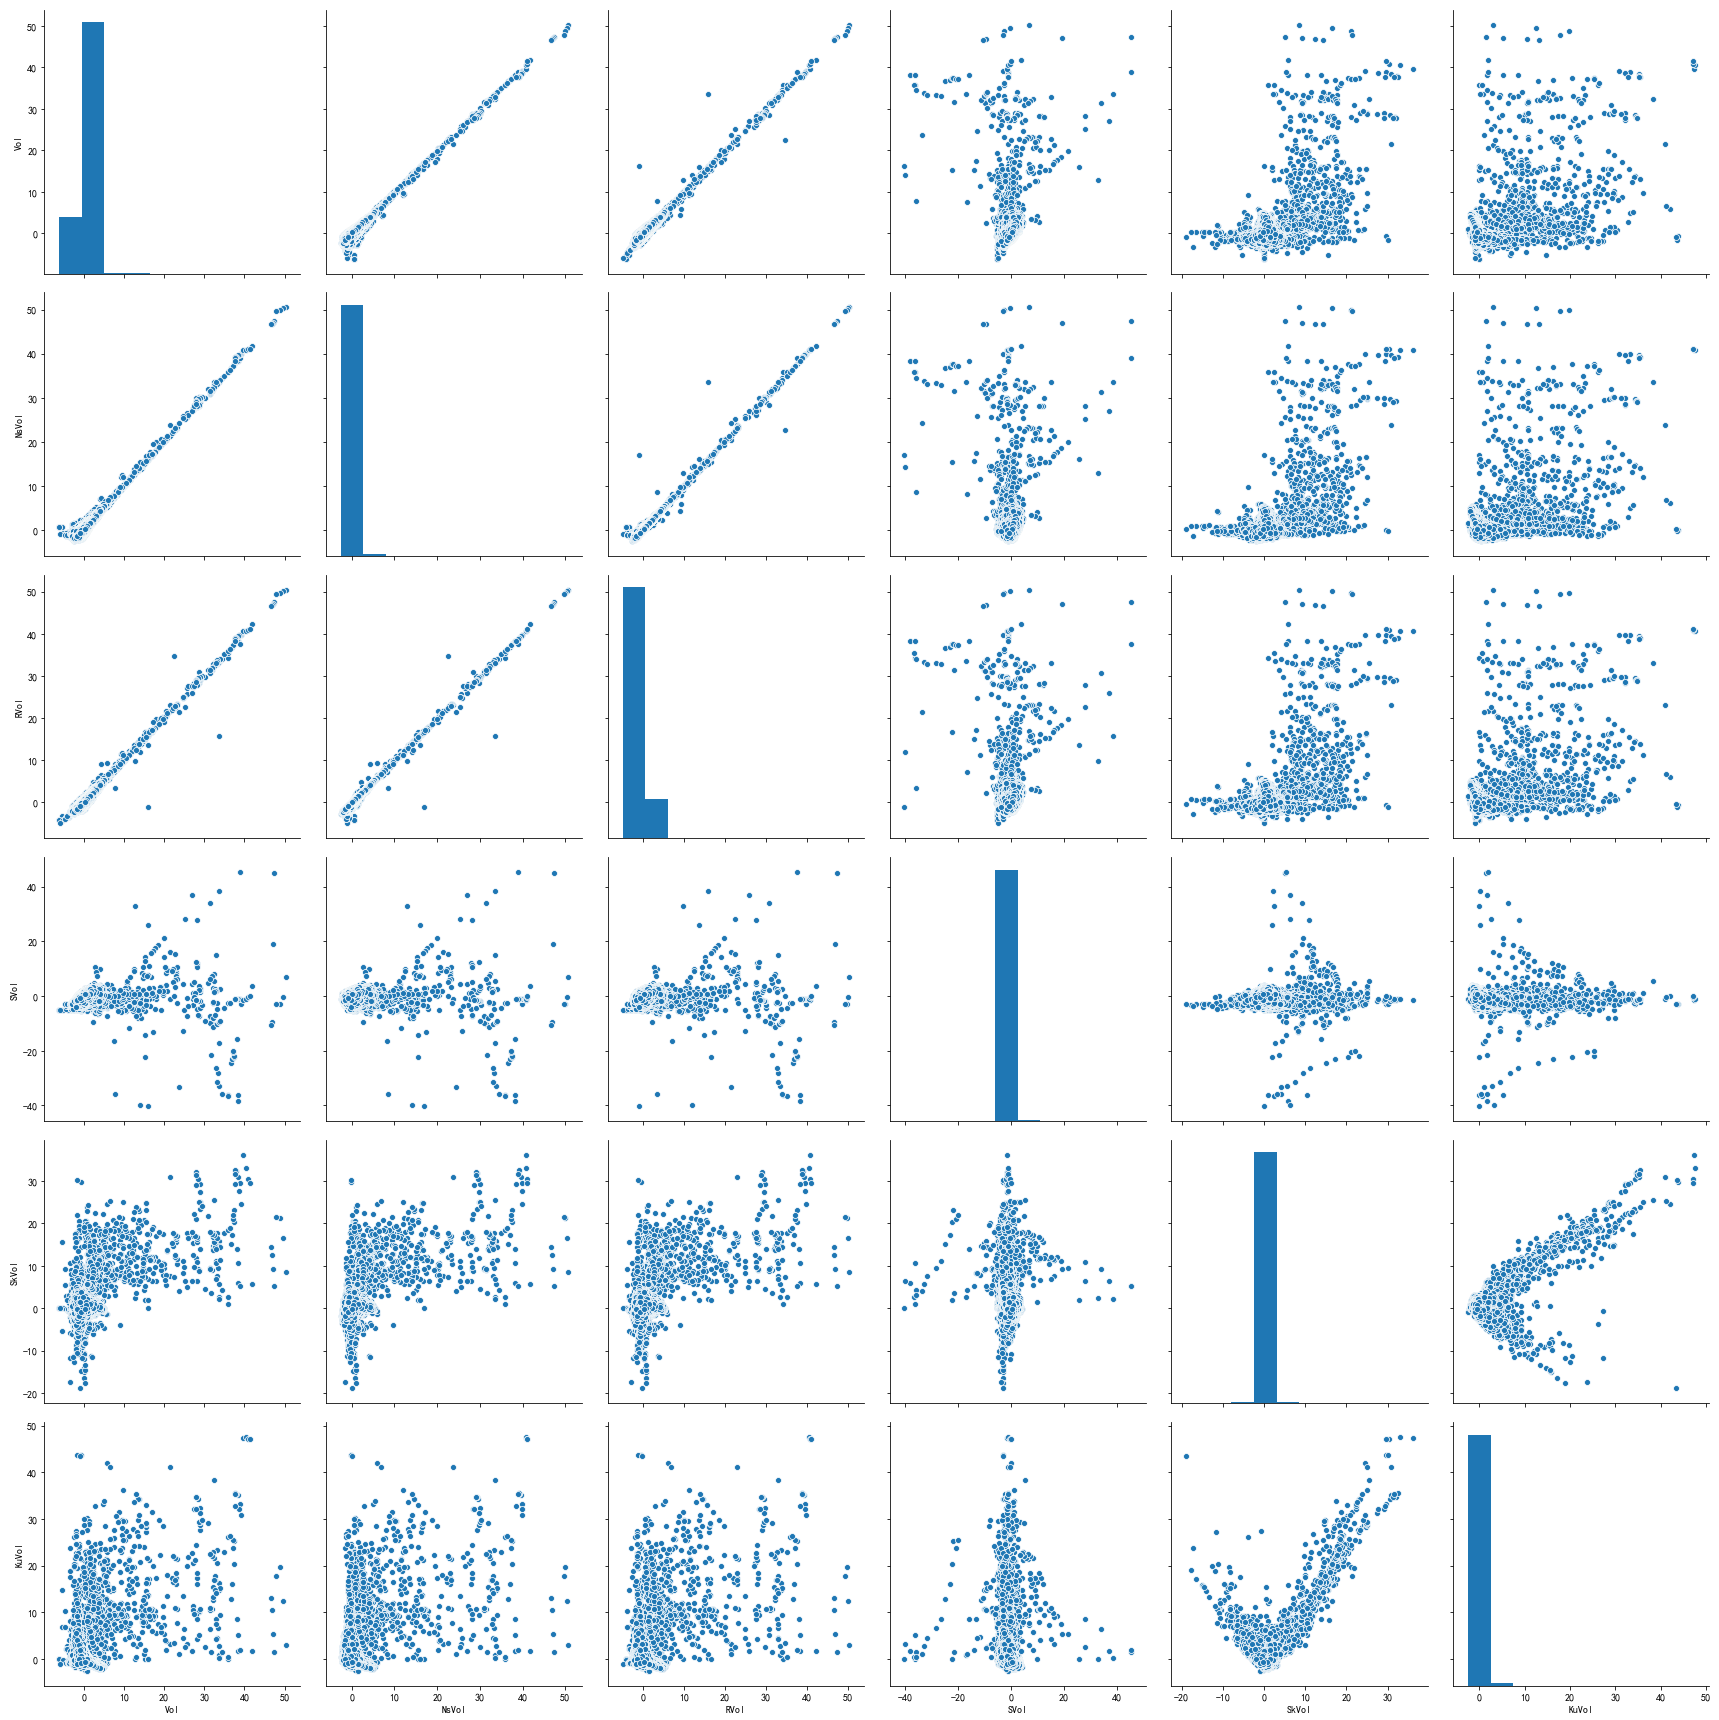

In [65]:
plt.figure(figsize=(15,12))
seaborn.pairplot(BarraFactorR_0[riskFactors],height=4)

In [68]:
# 某一期横截面
BarraFactorR_0_forCor=BarraFactorR_0[BarraFactorR_0['TRADE_DAYS']=='2019-07-31']
seaborn.pairplot(BarraFactorR_0_forCor[riskFactors],height=4)

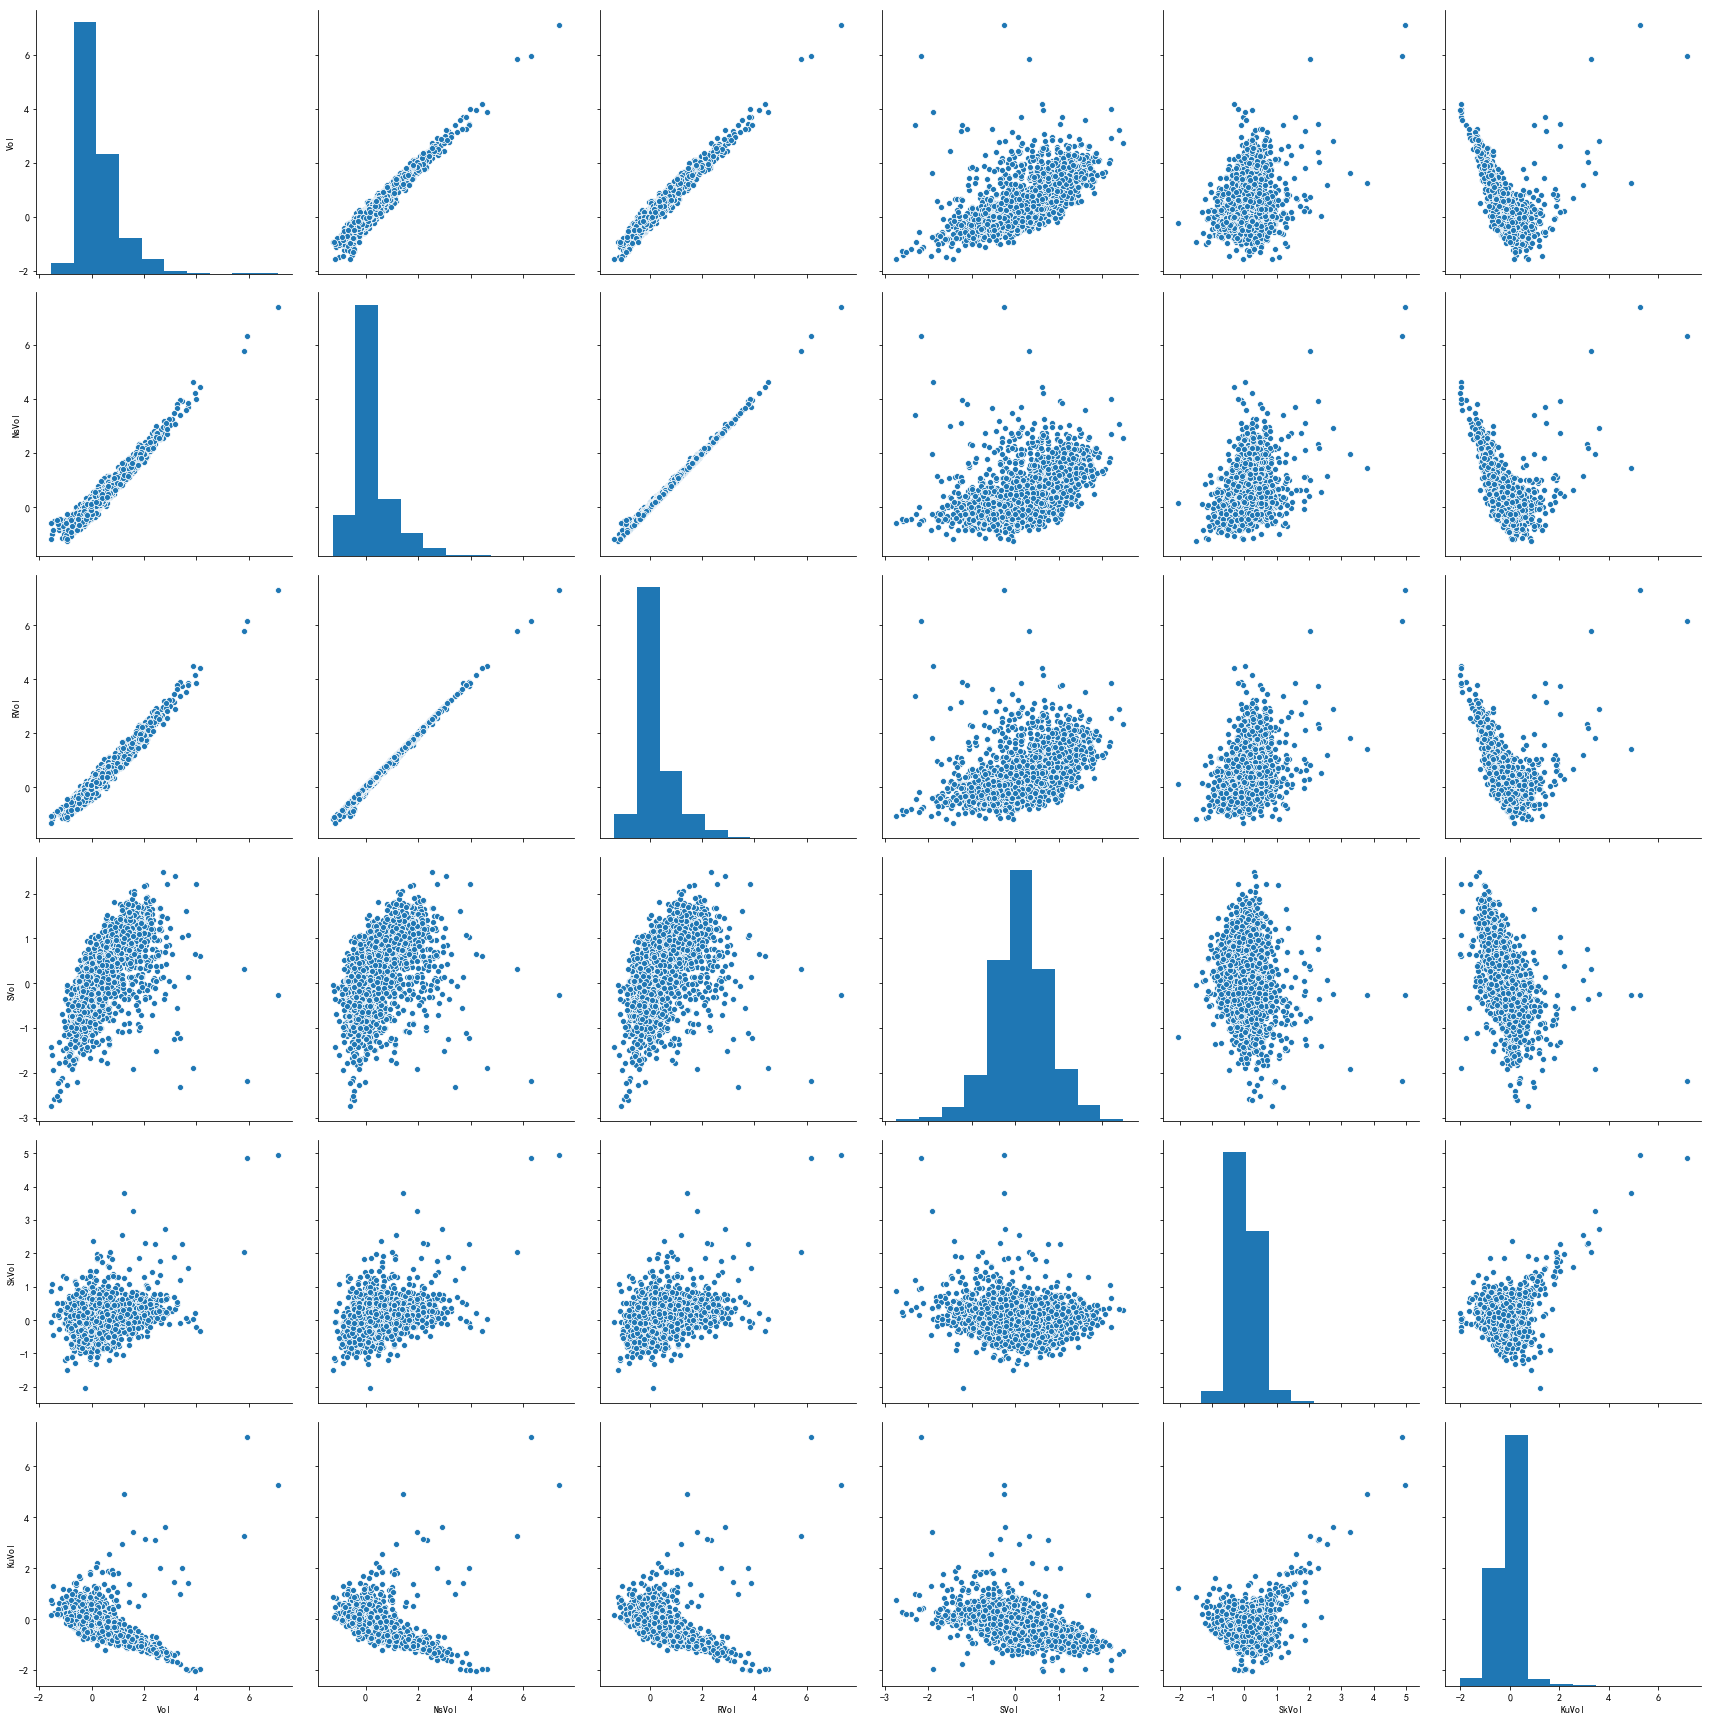

In [72]:
# 所有期平均值
seaborn.pairplot(BarraFactorR_0.groupby('S_INFO_WINDCODE').mean()[riskFactors],height=4)

In [73]:
BarraFactorR_0[riskFactors].corr()

,Vol,NsVol,RVol,SVol,SkVol,KuVol
Vol,1.000000,0.958819,0.967761,0.342130,0.410569,0.181566
NsVol,0.958819,1.000000,0.994923,0.125309,0.469715,0.247557
RVol,0.967761,0.994923,1.000000,0.155241,0.463673,0.234427
SVol,0.342130,0.125309,0.155241,1.000000,-0.111485,-0.266038
SkVol,0.410569,0.469715,0.463673,-0.111485,1.000000,0.521548
KuVol,0.181566,0.247557,0.234427,-0.266038,0.521548,1.000000


## 风险类因子的收益特征

In [74]:
riskFactorsNew = ['Vol','SVol','SkVol','KuVol',]

In [515]:
def QCut(df,colname,N):
    df_=df.copy()
    df_[colname+'_Grp']=pd.qcut(df_[colname],N,labels=False,duplicates='drop')
    return df_
def GroupRet(df,colname):
    df_=df.sort_values('TRADE_DAYS').copy()
    YearlyNextRet=((df_['NextRet'].fillna(0)+1).prod())**(12/len(df_))-1
    YearlyRet=((df_['Ret'].fillna(0)+1).prod())**(12/len(df_))-1
    YearlyNextStd=df_['NextRet'].std()*12**0.5
    YearlyStd=df_['Ret'].std()*12**0.5
    Sharpe=(YearlyNextRet-0.03)/YearlyNextStd
    Sharpepast=(YearlyRet-0.03)/YearlyStd
    return pd.DataFrame([df_[colname+'_Grp'].tolist()[0],YearlyNextRet,YearlyRet,Sharpe,Sharpepast],index=[colname+'_Grp','YNextRet','YRet','Sharpe','Sharpepast']).T

def FactorRetType(df,colname,N):
    BarraFactorR_0=df.copy()
    BarraFactorR_1=BarraFactorR_0[['S_INFO_WINDCODE','TRADE_DAYS','NextRet','Ret']+[colname]].copy()

    BarraFactorR_2=BarraFactorR_1.groupby('TRADE_DAYS').apply(QCut,colname,N=N).reset_index(drop=True)
    BarraFactorR_3=BarraFactorR_2.groupby(['TRADE_DAYS',colname+'_Grp']).mean().reset_index()

    BarraFactorR_4=BarraFactorR_3.groupby(colname+'_Grp').apply(GroupRet,colname).reset_index(drop=True).set_index(colname+'_Grp')
    f1=plt.figure(figsize=(16,3))
    for coln in range(len(BarraFactorR_4.columns)):
        col=BarraFactorR_4.columns[coln]
        ax1=f1.add_subplot(141+coln)
        plt.title('%s 按%s低至高排序'%(col,colname))
        plt.xlabel('低 ← %s 分组 → 高'%(colname))
        ax1.bar(BarraFactorR_4.index,BarraFactorR_4[col])
    plt.show()

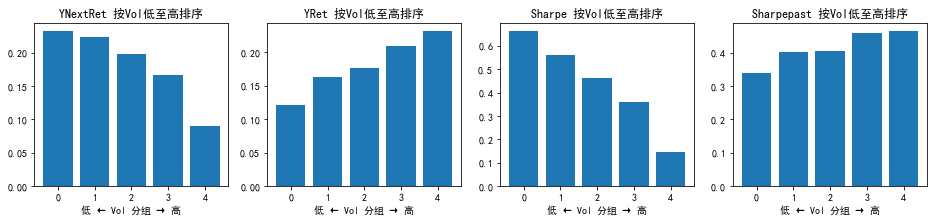

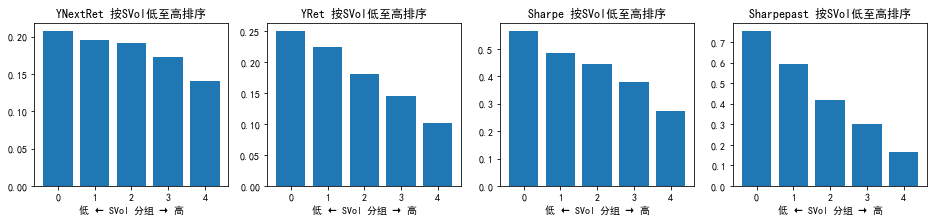

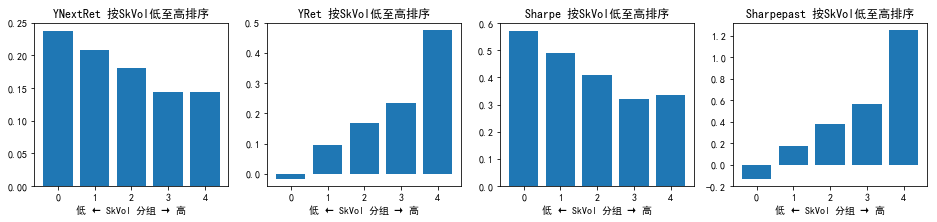

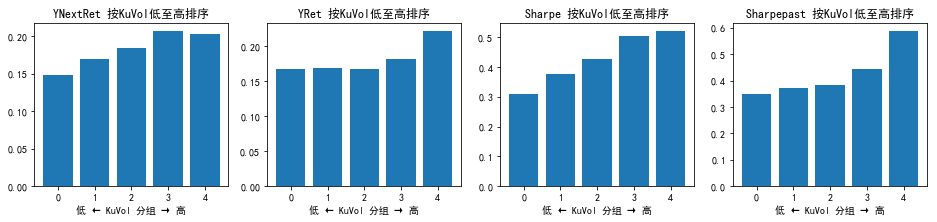

In [516]:
for colname in riskFactorsNew:
    FactorRetType(BarraFactorR_0,colname,N=5)

从NextRet排序的情况来看，一个资产组合具有历史低波动，那么投资者对其具有高预期风险，最终表现为高预期收益；  
大部分风险类因子的同期结果与传统金融学理论相合，同期，高风险对应高收益；  
普通波动率，在同期表现中，高风险对应高收益，风险调整收益（夏普比率）的单调性不明显，同样与金融理论相符，收益随风险上升的比率是一定的；  
贝塔波动率代表系统性风险，无论同期还是下期收益率均表现为低风险高收益的特点，与CAPM相左；  
峰度风险因子同期没有明显的收益单调性，但下期收益表现出一定的单调性，在最高峰度组（尾部最厚组）收益突然下降，符合常理；  

In [ ]:
BarraFactorR_0.to_csv('D:/StockDataBase/BarraFactorR_0.csv',index=False)

## 风险类因子净值曲线与同期Barra暴露

In [237]:
N_Risk=5
['Vol','SVol','SkVol','KuVol',]

In [522]:
OtherBarraList=['SIZE','LIQUIDITY','BM','GROWTH',]
colname = 'Vol'
BarraFactorR_eqt0=BarraFactorR_0.copy()
BarraFactorR_eqt2=BarraFactorR_eqt0.groupby('TRADE_DAYS').apply(QCut,colname,N=N_Risk).reset_index(drop=True)
# 每个组在每一天的平均指标
BarraFactorR_eqt3=BarraFactorR_eqt2.groupby(['TRADE_DAYS','%s_Grp'%(colname)]).mean().reset_index()
RiskEqt=(BarraFactorR_eqt3.pivot_table(columns='%s_Grp'%(colname),index='TRADE_DAYS',values='NextRet')+1).cumprod().shift(1).fillna(1)
RiskOtherDict={}
for OtherBarra in OtherBarraList:
    RiskOtherDict[OtherBarra]=BarraFactorR_eqt3.pivot_table(columns='%s_Grp'%(colname),index='TRADE_DAYS',values=OtherBarra)

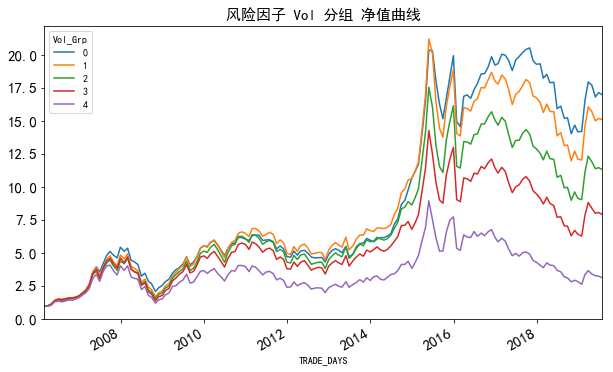

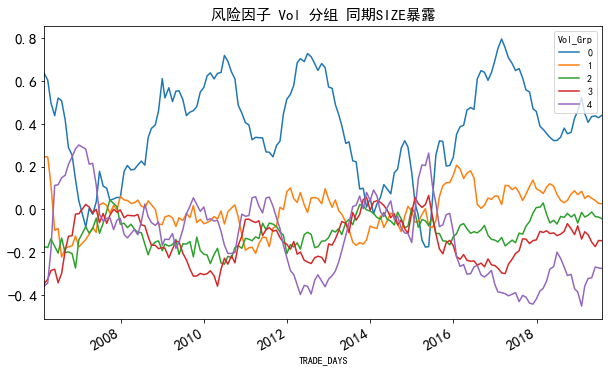

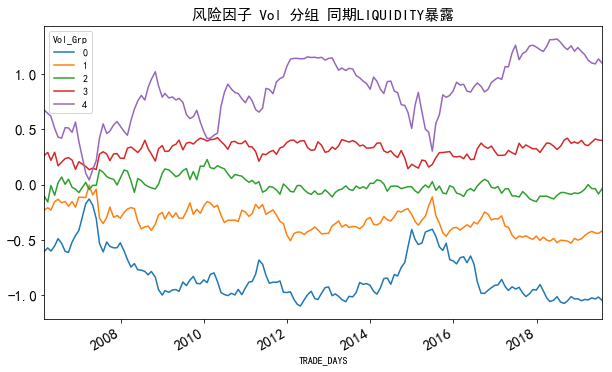

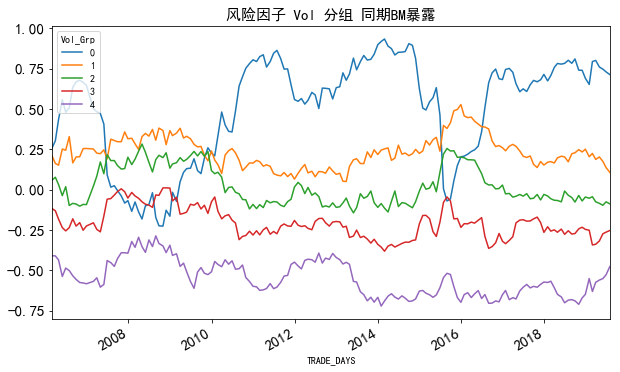

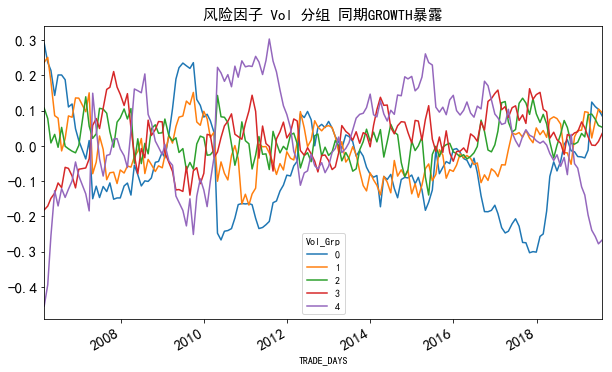

In [524]:
RiskEqt.plot(figsize=(10,6),fontsize=15)
plt.title('风险因子 %s 分组 净值曲线'%(colname),fontsize=15)
plt.show()
for OtherBarra in OtherBarraList:
    RiskOtherDict[OtherBarra].plot(figsize=(10,6),fontsize=15)
    plt.title('风险因子 %s 分组 同期%s暴露'%(colname,OtherBarra),fontsize=15)
    plt.show()

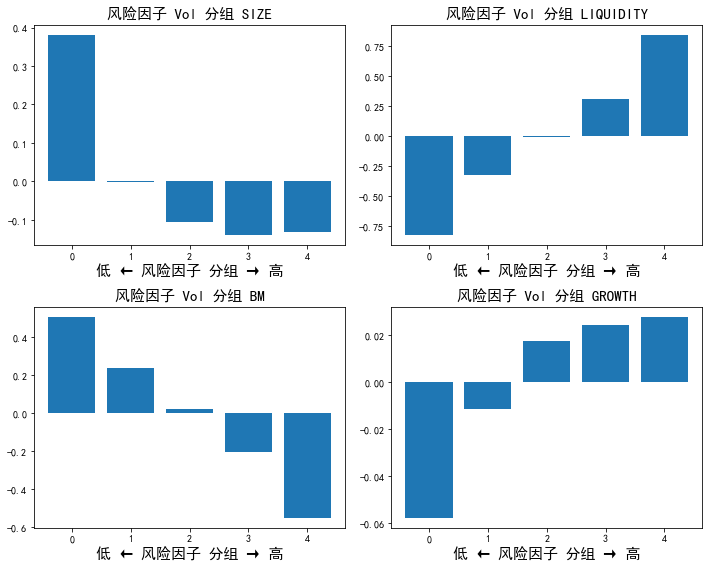

In [526]:
fig=plt.figure(figsize=(10,8))
for OtherBarraN in range(len(OtherBarraList)):
    OtherBarra=OtherBarraList[OtherBarraN]
    ax1=fig.add_subplot(221+OtherBarraN)
    ax1.bar(RiskOtherDict[OtherBarra].mean().index,RiskOtherDict[OtherBarra].mean())
    plt.title('风险因子 %s 分组 %s'%(colname,OtherBarra),fontsize=15)
    plt.xlabel('低 ← 风险因子 分组 → 高',fontsize=15)
plt.tight_layout()
plt.show()

## 低风险异象持续性

In [424]:
Bench=IndexPrices.set_index('TRADE_DAYS')
Bench['TRADE_DAYS']=Bench.index
Bench=Bench.apply(lambda x:x.resample('M').last()).reset_index(drop=True).rename(columns={'S_DQ_CLOSE':'中证500'})

In [425]:
RiskEqtBench = RiskEqt.merge(Bench[['TRADE_DAYS', '中证500']], on=['TRADE_DAYS'], how='left').set_index('TRADE_DAYS')
RiskEqtBench['中证500']=RiskEqtBench['中证500']/RiskEqtBench['中证500'].tolist()[0]

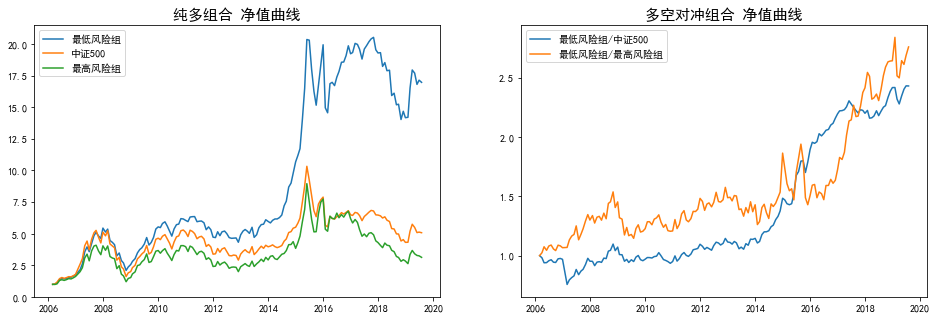

In [553]:
# 相对于某一基准的多空对冲
RiskEqtBench_Long=RiskEqtBench[[0,'中证500']].copy()
RiskEqtBench_LongShort=RiskEqtBench[[0,N_Risk-1]].copy()
LSeqt_Long=((RiskEqtBench_Long[0].pct_change()-RiskEqtBench_Long['中证500'].pct_change())+1).fillna(1).cumprod()
LSeqt_LongShort=((RiskEqtBench_LongShort[0].pct_change()-RiskEqtBench_LongShort[N_Risk-1].pct_change())+1).fillna(1).cumprod()

fig=plt.figure(figsize=(16,5))

ax1=fig.add_subplot(121)
ax1.plot(RiskEqtBench_Long)
ax1.plot(RiskEqtBench_LongShort[N_Risk-1])
plt.legend(labels=['最低风险组','中证500','最高风险组'],loc=0)
plt.title('纯多组合 净值曲线',fontsize=15)

ax2=fig.add_subplot(122)
ax2.plot(LSeqt_Long)
ax2.plot(LSeqt_LongShort)
plt.title('多空对冲组合 净值曲线',fontsize=15)
plt.legend(labels=['最低风险组/中证500','最低风险组/最高风险组'],loc=0)
plt.show()

In [561]:
def MonthIR(LSeqt_Long):
    return (LSeqt_Long[-1]**(12/len(LSeqt_Long))-1)/((LSeqt_Long.pct_change()).std()*12**0.5)

In [562]:
MonthIR(LSeqt_Long),MonthIR(LSeqt_LongShort)

(0.6042914270736685, 0.4384105003467345)

In [ ]:
# 年度胜率计算函数
def WinCompute(df,col1,col2,name):
    RiskEqtBench_Long=df.copy()
    RiskEqtBench_LongWin=RiskEqtBench_Long.pct_change().dropna()
    RiskEqtBench_LongWin[name]=RiskEqtBench_LongWin.apply(lambda x: 1 if x[col1]>x[col2] else 0,axis=1)
    RiskEqtBench_LongWinOut=RiskEqtBench_LongWin.apply(lambda x: x.resample('Y').mean())[[name]]
    RiskEqtBench_LongWinOut['Year']=[D.strftime('%Y-%m-%d')[:4] for D in RiskEqtBench_LongWinOut.index]
    RiskEqtBench_LongWinOut=pd.concat(
        [RiskEqtBench_LongWinOut,
         pd.DataFrame({name:[RiskEqtBench_LongWin.mean()[name]],'Year':['total']})])
    RiskEqtBench_LongWinOut=RiskEqtBench_LongWinOut.reset_index(drop=True)
    return RiskEqtBench_LongWinOut.set_index('Year')

In [563]:
pd.concat([WinCompute(RiskEqtBench_Long,0,'中证500','用中证500对冲'),WinCompute(RiskEqtBench_LongShort,0,N_Risk-1,'用最高波动组对冲')],axis=1)

,用中证500对冲,用最高波动组对冲
Year,,
2006,0.500000,0.500000
2007,0.727273,0.818182
2008,0.583333,0.666667
2009,0.416667,0.500000
2010,0.416667,0.583333
2011,0.750000,0.666667
2012,0.416667,0.500000
2013,0.416667,0.500000
2014,0.916667,0.666667


## Double-Sorting

In [417]:
def CumRet(df):
    df_=df.copy()
    key1=df_[sort_key1+'_Grp'].tolist()[0]
    df_0=(df_.pivot_table(columns=sort_key2+'_Grp',index='TRADE_DAYS',values='NextRet').shift(1).fillna(0)+1)
    df_1=df_0.prod()**(12/len(df_0))-1
    df_2=df_1.to_frame(key1).T
    return df_2
def Double_Sorting(Data,sort_key1,sort_key2,N):
    '''
    Data, DataFrame, 因子形式的数据框, 包含下期收益NextRet
    '''
    BarraFactorR_DS0=Data.copy()
    BarraFactorR_DS1=BarraFactorR_DS0.groupby('TRADE_DAYS').apply(QCut,sort_key1,N=N_Risk).reset_index(drop=True)
    BarraFactorR_DS2=BarraFactorR_DS1.groupby('TRADE_DAYS').apply(QCut,sort_key2,N=N_Risk).reset_index(drop=True)
    BarraFactorR_DS3=BarraFactorR_DS2.groupby(['TRADE_DAYS',sort_key1+'_Grp',sort_key2+'_Grp']).mean().reset_index()
    BarraFactorR_DS4=BarraFactorR_DS3.groupby(sort_key1+'_Grp').apply(CumRet)
    BarraFactorR_DS4.index=BarraFactorR_DS4.index.droplevel(1)
    BarraFactorR_DS5=BarraFactorR_DS4.T
    fig=plt.figure(figsize=(18,3))
    colList=BarraFactorR_DS5.columns
    for colN in range(len(colList)):
        col=colList[colN]
        ax=fig.add_subplot(1,N_Risk,colN+1)
        ax.bar(BarraFactorR_DS5[col].index,BarraFactorR_DS5[col].values)
        plt.xlabel('低 ← %s 分组 → 高\n%s低到高分组 第%d组'%(sort_key2,sort_key1,colN),fontsize=15)
    plt.show()
    return BarraFactorR_DS4

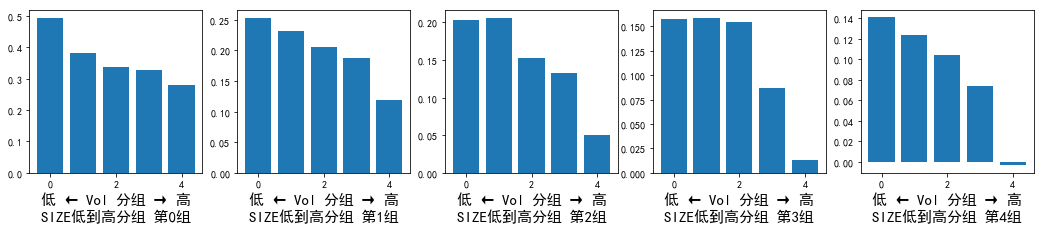

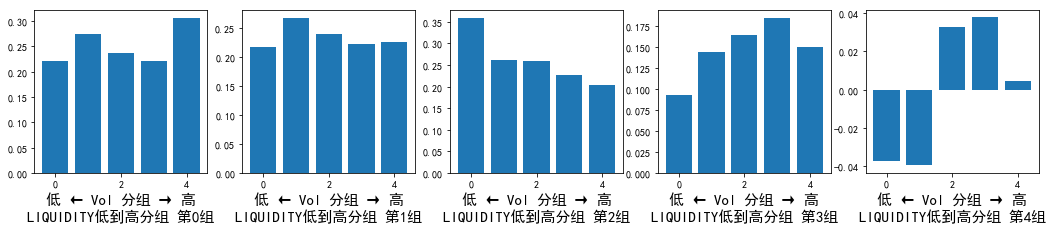

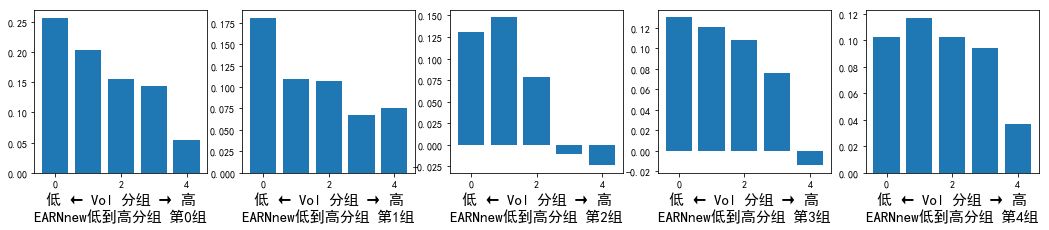

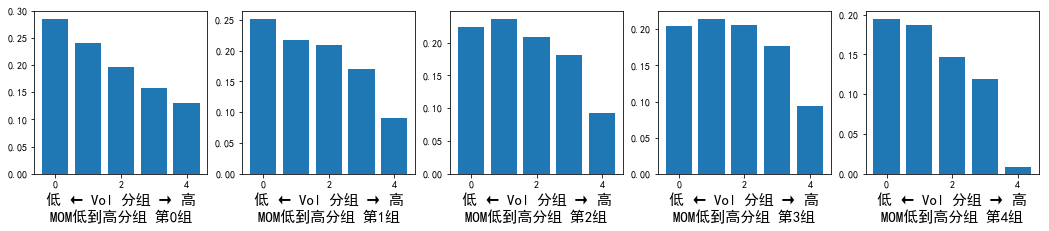

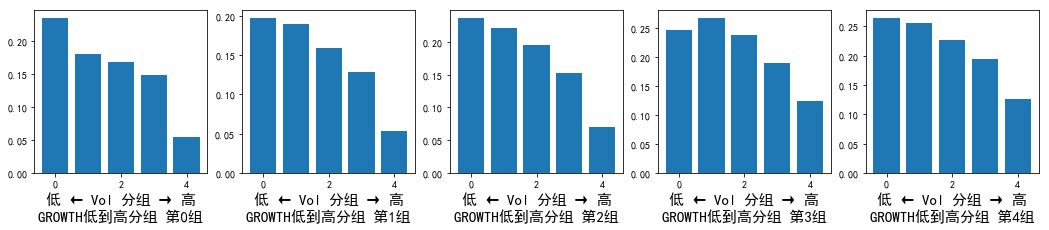

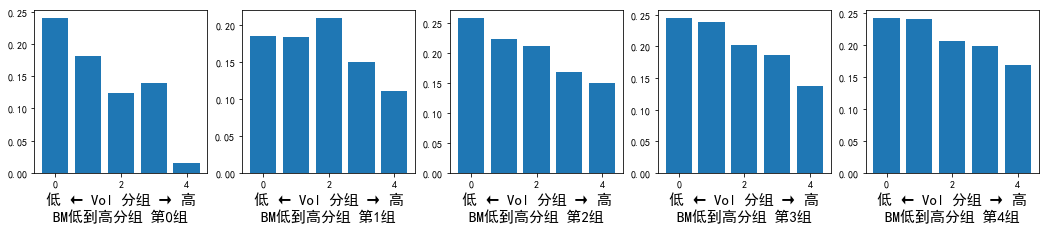

In [420]:
sort_key2='Vol'
N_Risk=5
for sort_key1 in ['SIZE','LIQUIDITY','EARNnew','MOM','GROWTH','BM']:
    Double_Sorting(BarraFactorR_0,sort_key1,sort_key2,N=N_Risk)

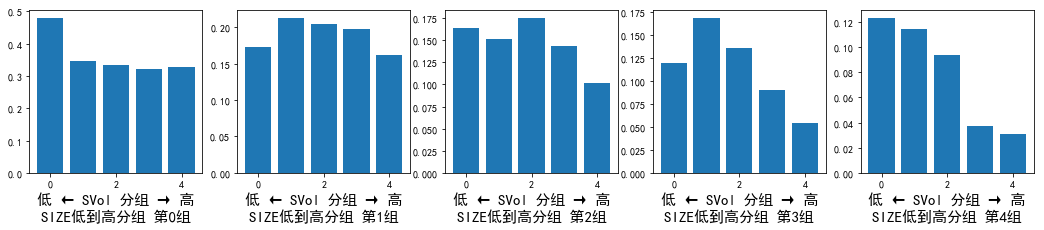

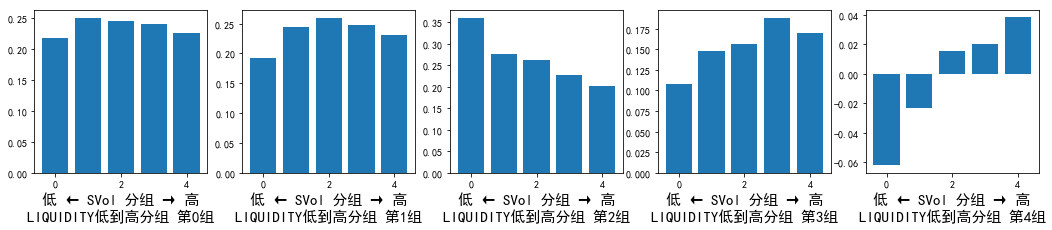

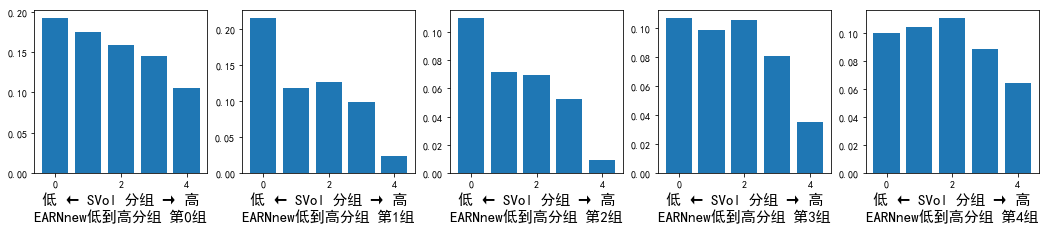

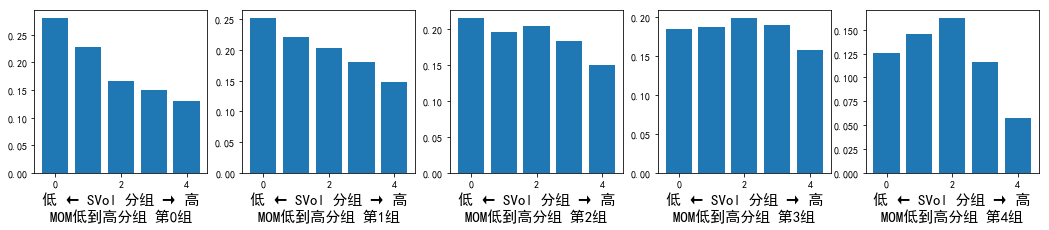

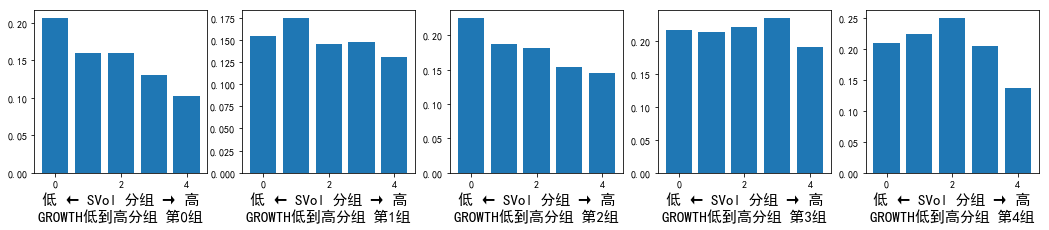

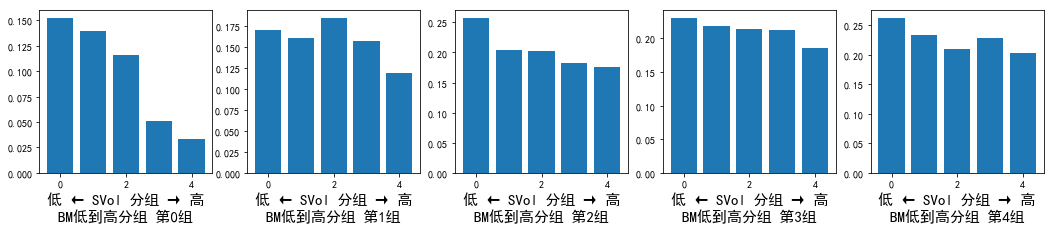

In [419]:
sort_key2='SVol'
N_Risk=5
for sort_key1 in ['SIZE','LIQUIDITY','EARNnew','MOM','GROWTH','BM']:
    Double_Sorting(BarraFactorR_0,sort_key1,sort_key2,N=N_Risk)

## 风险类因子与流动性的关系
流动性指标的计算方式是通过换手率计算的，中国股市由于其投资者结构的特点，高换手的股票并不等于高流动性，高换手的一个更主要因素是炒作氛围强，股票容易被高估，未来会回归到价值上，因此会有比较低的预期收益。

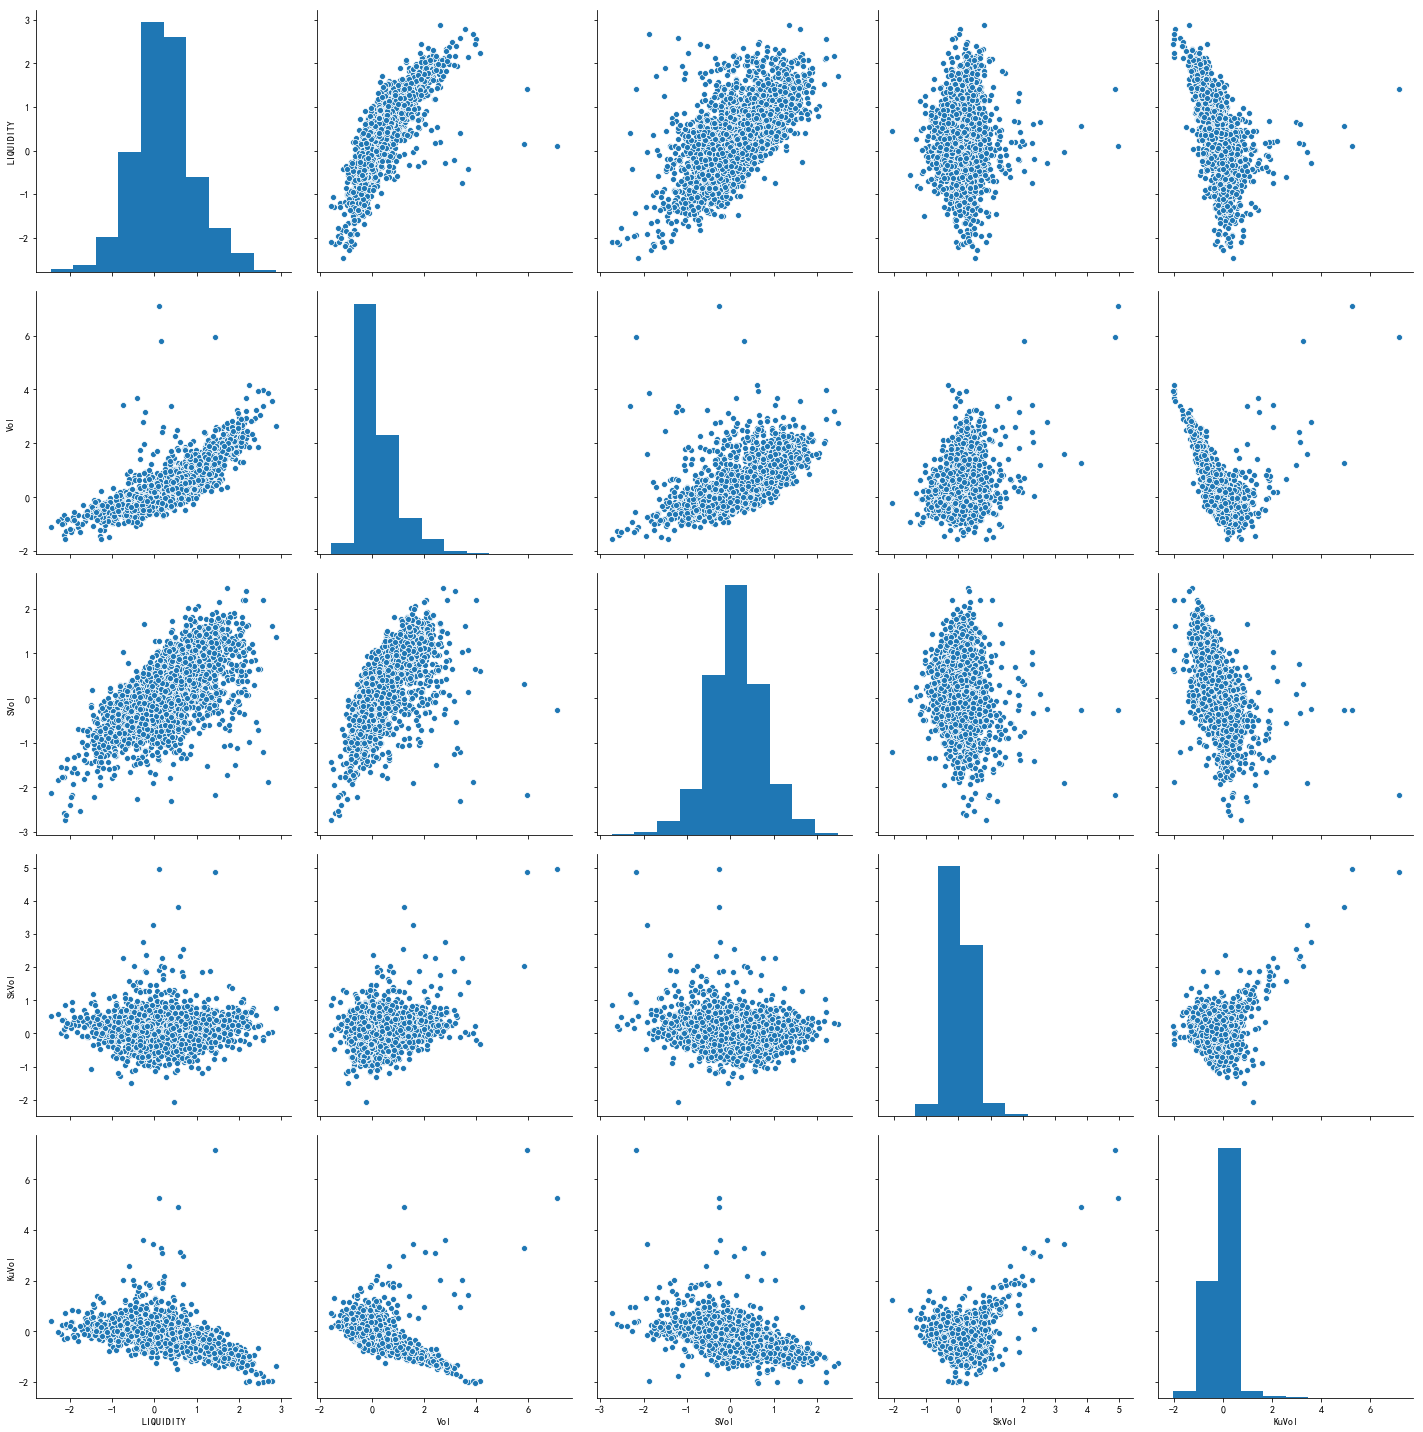

In [437]:
BarraFactorR_DayMean=BarraFactorR_0.groupby('S_INFO_WINDCODE').mean().reset_index()
seaborn.pairplot(BarraFactorR_DayMean[['LIQUIDITY']+riskFactorsNew],height=4)

In [447]:
def Single_Sorting(Data,sort_key1,N):
    '''
    Data, DataFrame, 因子形式的数据框, 包含下期收益NextRet
    '''
    BarraFactorR_DS0=Data.copy()
    BarraFactorR_DS1=BarraFactorR_DS0.groupby('TRADE_DAYS').apply(QCut,sort_key1,N=N_Risk).reset_index(drop=True)
    BarraFactorR_DS2=BarraFactorR_DS1.groupby(['TRADE_DAYS',sort_key1+'_Grp']).mean().reset_index()
    BarraFactorR_DS3=BarraFactorR_DS2.pivot_table(index='TRADE_DAYS',columns=sort_key1+'_Grp',values='NextRet')
    BarraFactorR_DS4=(BarraFactorR_DS3.shift(1).fillna(0)+1).cumprod()

    return BarraFactorR_DS4

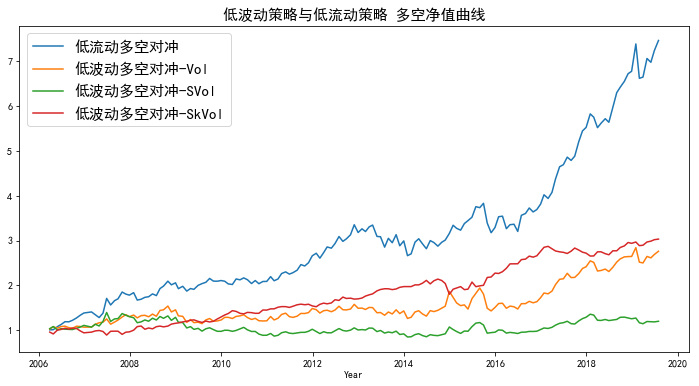

In [573]:
plt.figure(figsize=(12,6))
plt.plot((LIQUIDITY_Sort_s+1).cumprod())
plt.plot((Vol_Sort_s+1).cumprod())
plt.plot((SVol_Sort_s+1).cumprod())
plt.plot((SkVol_Sort_s+1).cumprod())
plt.xlabel('Year')
plt.title('低波动策略与低流动策略 多空净值曲线',fontsize=15)
plt.legend(['低流动多空对冲','低波动多空对冲-Vol','低波动多空对冲-SVol','低波动多空对冲-SkVol'],loc=0,fontsize=15)
plt.show()

,Vol
TRADE_DAYS,
2006-03-31,1.024711
2006-04-28,1.074913
2006-05-31,1.045079
2006-06-30,1.081092
2006-07-31,1.089532
2006-08-31,1.056335
2006-09-29,1.042835
2006-10-31,1.088460
2006-11-30,1.082535


In [492]:
Nsort=5

In [493]:
LIQUIDITY_Sort = Single_Sorting(BarraFactorR_0,'LIQUIDITY',Nsort)
LIQUIDITY_Sort_pct = LIQUIDITY_Sort.pct_change().dropna()
LIQUIDITY_Sort_s=(LIQUIDITY_Sort_pct[0]-LIQUIDITY_Sort_pct[Nsort-1]).to_frame('LQT')

In [494]:
SIZE_Sort = Single_Sorting(BarraFactorR_0,'SIZE',Nsort)
SIZE_Sort_pct = SIZE_Sort.pct_change().dropna()
SIZE_Sort_s=(SIZE_Sort_pct[0]-SIZE_Sort_pct[Nsort-1]).to_frame('SMB')

In [495]:
BM_Sort = Single_Sorting(BarraFactorR_0,'BM',Nsort)
BM_Sort_pct = BM_Sort.pct_change().dropna()
BM_Sort_s=(BM_Sort_pct[0]-BM_Sort_pct[Nsort-1]).to_frame('HML')

In [496]:
Vol_Sort = Single_Sorting(BarraFactorR_0,'Vol',5)
Vol_Sort_pct = Vol_Sort.pct_change().dropna()
Vol_Sort_s=(Vol_Sort_pct[0]-Vol_Sort_pct[5-1]).to_frame('Vol')

In [505]:
SVol_Sort = Single_Sorting(BarraFactorR_0,'SVol',5)
SVol_Sort_pct = SVol_Sort.pct_change().dropna()
SVol_Sort_s=(SVol_Sort_pct[0]-SVol_Sort_pct[5-1]).to_frame('SVol')

In [506]:
SkVol_Sort = Single_Sorting(BarraFactorR_0,'SkVol',5)
SkVol_Sort_pct = SkVol_Sort.pct_change().dropna()
SkVol_Sort_s=(SkVol_Sort_pct[0]-SkVol_Sort_pct[5-1]).to_frame('SkVol')

In [512]:
KuVol_Sort = Single_Sorting(BarraFactorR_0,'KuVol',5)
KuVol_Sort_pct = KuVol_Sort.pct_change().dropna()
KuVol_Sort_s=(KuVol_Sort_pct[0]-KuVol_Sort_pct[5-1]).to_frame('KuVol')

In [497]:
Bench_s=Bench.set_index('TRADE_DAYS')['中证500'].pct_change().to_frame('MKT')

In [513]:
RegData = LIQUIDITY_Sort_s.merge(
    SIZE_Sort_s,left_index=True,right_index=True).merge(
    BM_Sort_s,left_index=True,right_index=True).merge(
    Bench_s,left_index=True,right_index=True).merge(
    Vol_Sort_s,left_index=True,right_index=True).merge(
    SVol_Sort_s,left_index=True,right_index=True).merge(
    SkVol_Sort_s,left_index=True,right_index=True).merge(
    KuVol_Sort_s,left_index=True,right_index=True)

In [504]:
print(sm.OLS(RegData['Vol'],sm.add_constant(RegData[['SMB','HML','MKT']])).fit().summary())
print(sm.OLS(RegData['Vol'],sm.add_constant(RegData[['SMB','HML','MKT','LQT']])).fit().summary())
# print(sm.OLS(RegData['Vol'],sm.add_constant(RegData[['HML','MKT','LQT']])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    Vol   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     67.56
Date:                Mon, 21 Oct 2019   Prob (F-statistic):           4.74e-28
Time:                        21:05:59   Log-Likelihood:                 313.75
No. Observations:                 160   AIC:                            -619.5
Df Residuals:                     156   BIC:                            -607.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.003      3.231      0.0

In [510]:
print(sm.OLS(RegData['SVol'],sm.add_constant(RegData[['SMB','HML','MKT']])).fit().summary())
print(sm.OLS(RegData['SVol'],sm.add_constant(RegData[['SMB','HML','MKT','LQT']])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   SVol   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     37.98
Date:                Mon, 21 Oct 2019   Prob (F-statistic):           1.75e-18
Time:                        21:07:10   Log-Likelihood:                 304.36
No. Observations:                 160   AIC:                            -600.7
Df Residuals:                     156   BIC:                            -588.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.003      2.830      0.0

C:\Users\Thinkpad\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [511]:
print(sm.OLS(RegData['SkVol'],sm.add_constant(RegData[['SMB','HML','MKT']])).fit().summary())
print(sm.OLS(RegData['SkVol'],sm.add_constant(RegData[['SMB','HML','MKT','LQT']])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  SkVol   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     59.39
Date:                Mon, 21 Oct 2019   Prob (F-statistic):           1.15e-25
Time:                        21:07:28   Log-Likelihood:                 395.90
No. Observations:                 160   AIC:                            -783.8
Df Residuals:                     156   BIC:                            -771.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.693      0.4

C:\Users\Thinkpad\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [514]:
print(sm.OLS(RegData['KuVol'],sm.add_constant(RegData[['SMB','HML','MKT']])).fit().summary())
print(sm.OLS(RegData['KuVol'],sm.add_constant(RegData[['SMB','HML','MKT','LQT']])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  KuVol   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     41.27
Date:                Mon, 21 Oct 2019   Prob (F-statistic):           1.09e-19
Time:                        21:08:44   Log-Likelihood:                 347.08
No. Observations:                 160   AIC:                            -686.2
Df Residuals:                     156   BIC:                            -673.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.445      0.6

C:\Users\Thinkpad\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [350]:
df_2

Vol_Grp,0,1,2,3,4
0,0.234944,0.224337,0.198291,0.166742,0.088914
